In [47]:
import random
import matplotlib.pyplot as plt
from collections import deque
import numpy as np

# --- Гиперпараметры ---
NUM_GLASSES = 5
STATE_GRANULARITY = 5    # Шаг для округления состояний. Ключевой параметр!
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.95
EPSILON = 1.0
EPSILON_DECAY = 0.9995   # Чуть замедлим затухание для более сложных задач
MIN_EPSILON = 0.01
EPISODES = 10000         # Увеличим число эпизодов для обучения на разных задачах

In [48]:
def generate_random_state(num_glasses):
    """
    Генерирует случайное начальное состояние, сумма объемов в котором
    гарантированно делится на количество стаканов.
    """
    while True:
        # Генерируем случайные объемы от 1 до 100
        state = [random.randint(1, 100) for _ in range(num_glasses)]
        if sum(state) % num_glasses == 0:
            return tuple(state)

In [49]:
class CompoteEnv:
    def __init__(self, num_glasses):
        self.num_glasses = num_glasses

    def reset(self, initial_state):
        """Сбрасывает среду в заданное начальное состояние."""
        self.initial_state = tuple(initial_state)
        self.target_volume = sum(initial_state) // self.num_glasses
        self.goal_state = tuple([self.target_volume] * self.num_glasses)
        self.state = self.initial_state
        return self.state

    def step(self, source_glass_idx):
        if list(self.state)[source_glass_idx] <= self.target_volume:
            return self.state, -10, False # Наказание за бесполезное действие

        next_state_list = list(self.state)
        pourable_amount = next_state_list[source_glass_idx] - self.target_volume
        next_state_list[source_glass_idx] = self.target_volume
        
        for j in range(self.num_glasses):
            if source_glass_idx == j or pourable_amount <= 0:
                continue
            if next_state_list[j] < self.target_volume:
                needed = self.target_volume - next_state_list[j]
                transfer = min(pourable_amount, needed)
                next_state_list[j] += transfer
                pourable_amount -= transfer
        
        self.state = tuple(next_state_list)
        done = (self.state == self.goal_state)
        reward = 100 if done else -1
        return self.state, reward, done

In [50]:
class QLearningAgent:
    def __init__(self, actions, learning_rate, discount_factor, epsilon, granularity):
        self.actions = actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.granularity = granularity
        self.q_table = {}

    def _discretize_state(self, state):
        """Округляет точное состояние до ближайшего значения с шагом гранулярности."""
        discretized = [int(round(x / self.granularity)) * self.granularity for x in state]
        return tuple(discretized)

    def get_q_value(self, state, action):
        """Использует дискретное состояние как ключ для Q-таблицы."""
        discretized_state = self._discretize_state(state)
        return self.q_table.get((discretized_state, action), 0.0)

    def choose_action(self, state):
        """
        Выбирает действие на основе дискретного состояния.
        В режиме эксплуатации игнорирует заведомо бесполезные действия.
        """
        if random.random() < self.epsilon:
            # Режим исследования: можно выбрать любое действие
            return random.choice(self.actions)
        else:
            # Режим эксплуатации: будем умнее
            target_volume = sum(state) // len(state)
            
            # 1. Находим все возможные Q-значения
            q_values = [self.get_q_value(state, a) for a in self.actions]
            
            # 2. Составляем список "полезных" действий (где в стакане есть излишек)
            # Это предотвратит выбор заведомо проигрышных ходов в режиме эксплуатации
            useful_actions = [a for a in self.actions if state[a] > target_volume]
            
            # Если по какой-то причине полезных действий не нашлось (например, мы уже в цели),
            # чтобы избежать ошибки, просто вернем любое действие.
            if not useful_actions:
                return random.choice(self.actions)
            
            # 3. Находим лучшее Q-значение СРЕДИ ПОЛЕЗНЫХ действий
            best_q_among_useful = -float('inf')
            for action in useful_actions:
                if q_values[action] > best_q_among_useful:
                    best_q_among_useful = q_values[action]

            # 4. Собираем все полезные действия с наилучшим Q-значением
            best_actions = [a for a in useful_actions if q_values[a] == best_q_among_useful]
            
            return random.choice(best_actions)


    def update_q_value(self, state, action, reward, next_state):
        """Обновляет Q-таблицу, используя дискретные состояния."""
        discretized_state = self._discretize_state(state)
        old_q = self.get_q_value(state, action)
        
        future_q_values = [self.get_q_value(next_state, a) for a in self.actions]
        max_future_q = max(future_q_values) if future_q_values else 0
        
        new_q = old_q + self.lr * (reward + self.gamma * max_future_q - old_q)
        
        self.q_table[(discretized_state, action)] = new_q

In [51]:
env = CompoteEnv(NUM_GLASSES)
possible_actions = list(range(NUM_GLASSES))
agent = QLearningAgent(
    actions=possible_actions,
    learning_rate=LEARNING_RATE,
    discount_factor=DISCOUNT_FACTOR,
    epsilon=EPSILON,
    granularity=STATE_GRANULARITY
)

rewards_per_episode = []
moving_avg_rewards = deque(maxlen=100)
moving_averages = []

print("--- Начало обучения на случайных задачах ---")
for episode in range(EPISODES):
    # Генерируем новую случайную задачу для каждого эпизода!
    initial_state = generate_random_state(NUM_GLASSES)
    state = env.reset(initial_state)
    
    total_reward = 0
    done = False
    
    for step in range(15): # Дадим агенту чуть больше шагов на случай сложных задач
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.update_q_value(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        if done:
            break
            
    if agent.epsilon > MIN_EPSILON:
        agent.epsilon *= EPSILON_DECAY

    rewards_per_episode.append(total_reward)
    moving_avg_rewards.append(total_reward)
    moving_averages.append(sum(moving_avg_rewards) / len(moving_avg_rewards))
    
    if (episode + 1) % 1000 == 0:
        print(f"Эпизод {episode + 1}/{EPISODES} | Средняя награда (100 эп.): {moving_averages[-1]:.2f} | Epsilon: {agent.epsilon:.3f}")

print("--- Обучение завершено ---")

--- Начало обучения на случайных задачах ---
Эпизод 1000/10000 | Средняя награда (100 эп.): 82.75 | Epsilon: 0.606
Эпизод 2000/10000 | Средняя награда (100 эп.): 91.75 | Epsilon: 0.368
Эпизод 3000/10000 | Средняя награда (100 эп.): 95.87 | Epsilon: 0.223
Эпизод 4000/10000 | Средняя награда (100 эп.): 96.96 | Epsilon: 0.135
Эпизод 5000/10000 | Средняя награда (100 эп.): 97.13 | Epsilon: 0.082
Эпизод 6000/10000 | Средняя награда (100 эп.): 97.78 | Epsilon: 0.050
Эпизод 7000/10000 | Средняя награда (100 эп.): 97.79 | Epsilon: 0.030
Эпизод 8000/10000 | Средняя награда (100 эп.): 98.16 | Epsilon: 0.018
Эпизод 9000/10000 | Средняя награда (100 эп.): 98.34 | Epsilon: 0.011
Эпизод 10000/10000 | Средняя награда (100 эп.): 98.44 | Epsilon: 0.010
--- Обучение завершено ---


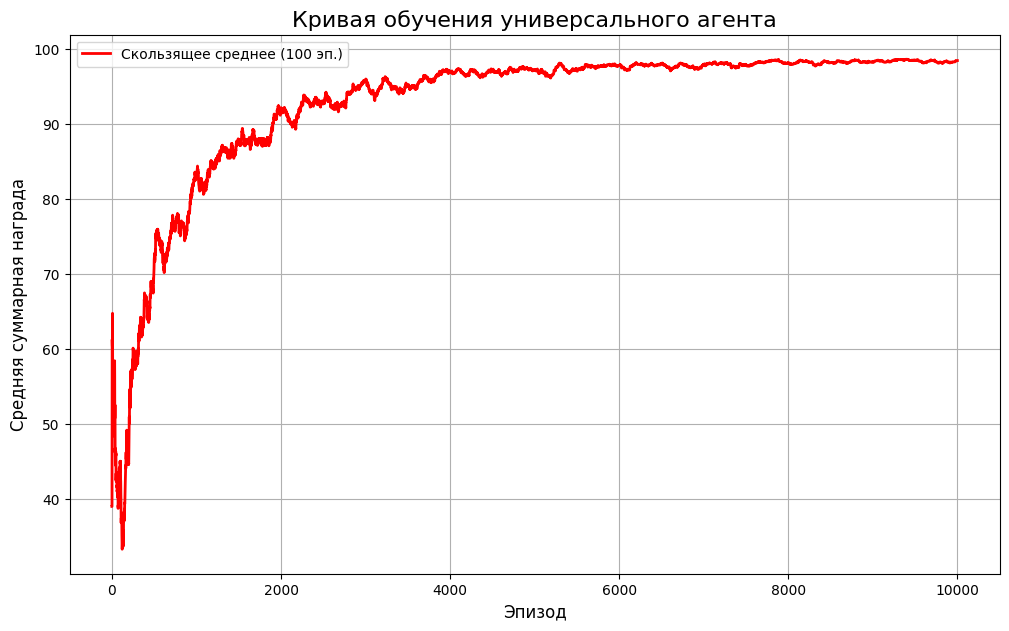


--- Демонстрация работы на новой задаче ---
Случайная задача: (1, 27, 15, 89, 68)
Цель: (40, 40, 40, 40, 40)

Шаг 1: Агент поднял стакан 4 -> Результат: (40, 37, 15, 40, 68)
Шаг 2: Агент поднял стакан 5 -> Результат: (40, 40, 40, 40, 40)

Задача решена!


In [52]:
# Кривая обучения (остается без изменений)
plt.figure(figsize=(12, 7))
plt.plot(moving_averages, label='Скользящее среднее (100 эп.)', color='red', linewidth=2)
plt.title('Кривая обучения универсального агента', fontsize=16)
plt.xlabel('Эпизод', fontsize=12)
plt.ylabel('Средняя суммарная награда', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# --- Улучшенная демонстрация ---
print("\n--- Демонстрация работы на новой задаче ---")
initial_state = generate_random_state(NUM_GLASSES)
state = env.reset(initial_state)
print(f"Случайная задача: {state}")
print(f"Цель: {env.goal_state}\n")

agent.epsilon = 0 # Включаем режим чистой эксплуатации
path = [state]
for i in range(10): # Максимум 10 попыток
    action = agent.choose_action(state)
    
    # Запомним состояние до хода, чтобы проверить, изменилось ли оно
    state_before_action = state
    
    next_state, _, done = env.step(action)
    state = next_state
    
    # Проверяем, был ли ход успешным (состояние изменилось)
    if state != state_before_action:
        path.append(state)
        print(f"Шаг {len(path)-1}: Агент поднял стакан {action+1} -> Результат: {state}")
    else:
        # Этого блока мы теперь почти не увидим из-за улучшений в choose_action,
        # но оставим его на всякий случай.
        print(f"Попытка {i+1}: Агент выбрал бесполезное действие (поднять стакан {action+1}). Пробует снова.")

    if done:
        print("\nЗадача решена!")
        break

# Проверяем, было ли решение найдено в конце
if not done:
    print("\nНе удалось решить задачу за 10 попыток.")